Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://blinkist-useast_1_virginia.snowflakecomputing.com/console/login?login_name=meri-kris.jaama%40go1.com&browser_mode_redirect_port=58101&proof_key=rW6%2FFHQKxPwbwbe4lShgE8UL6pvGkZI4dq4w5FLnd1g%3D to authenticate...
Connected to Snowflake as meri-kris.jaama@go1.com
Fetching available dates from new table...
Found 46 dates in new table: [datetime.date(2025, 1, 21), datetime.date(2025, 1, 22), datetime.date(2025, 1, 23), datetime.date(2025, 1, 24), datetime.date(2025, 1, 25), datetime.date(2025, 1, 26), datetime.date(2025, 1, 27), datetime.date(2025, 1, 28), datetime.date(2025, 1, 29), datetime.date(2025, 1, 30), datetime.date(2025, 1, 31), datetime.date(2025, 2, 1), datetime.date(2025, 2, 2), datetime.date(2025, 2, 3), datetime.date(2025,

,Channel,Count,MAE New,MAE Prod,MAE Improvement %,MAPE New %,MAPE Prod %,MAPE Improvement %,New Better %
0,paid_content,112,111.540228,89.071632,-25.225311,20.472935,19.643861,-4.220522,36.607143
1,paid_social,5,162.940978,57.842934,-181.695560,26.332442,22.441317,-17.339113,0.000000



Creating visualizations...


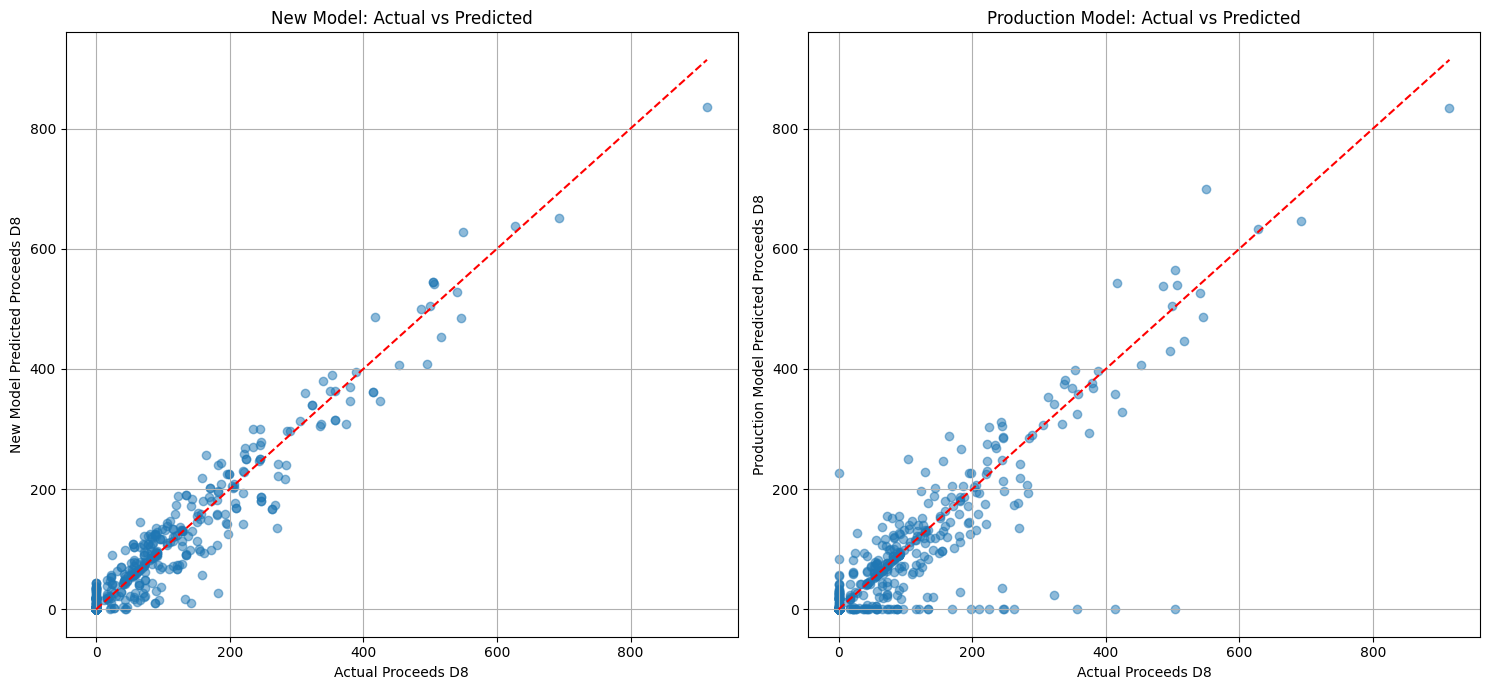

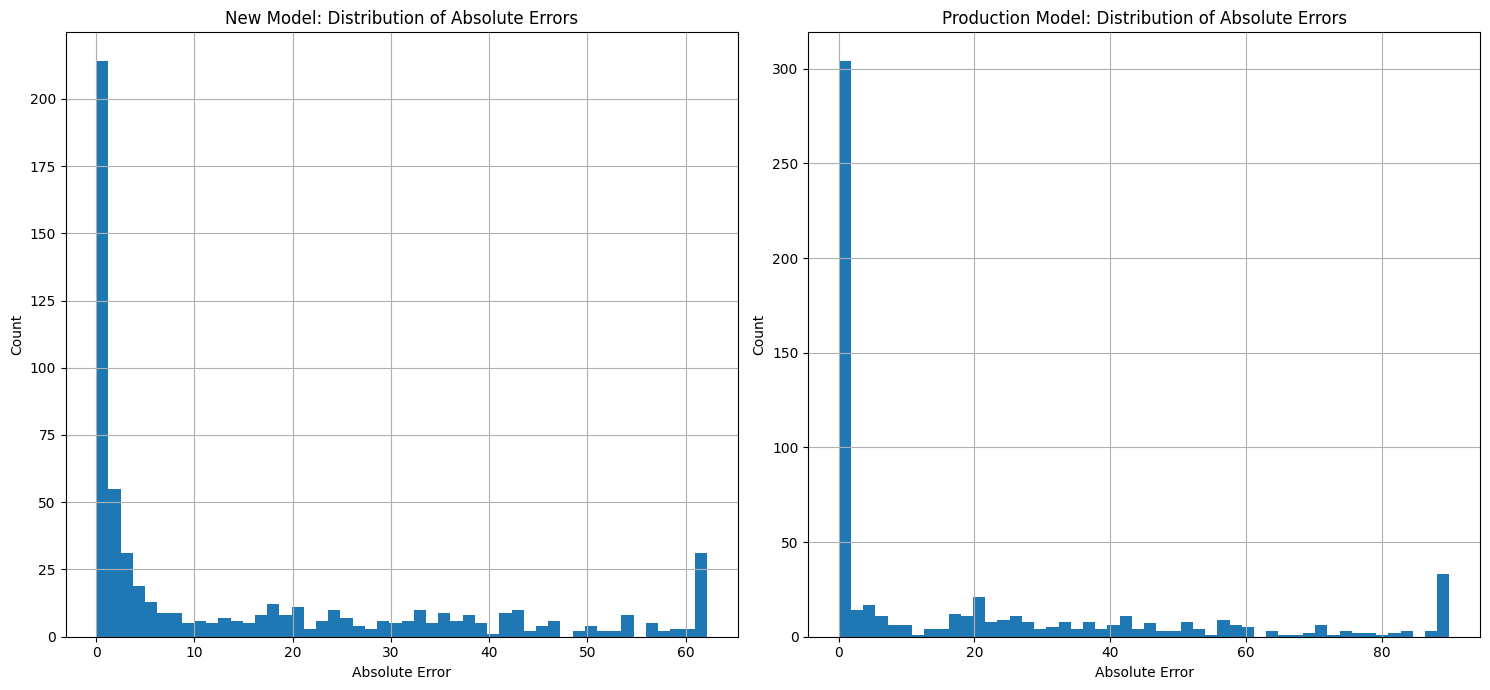

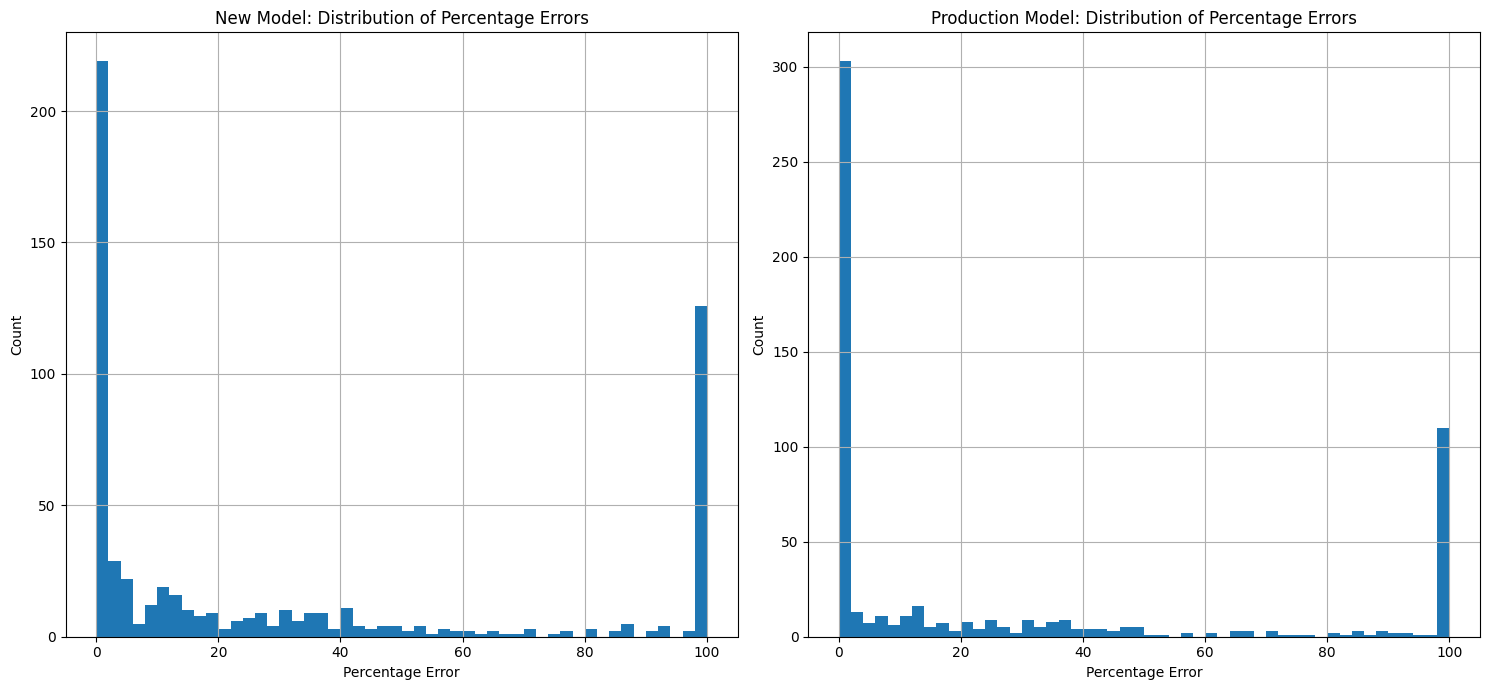

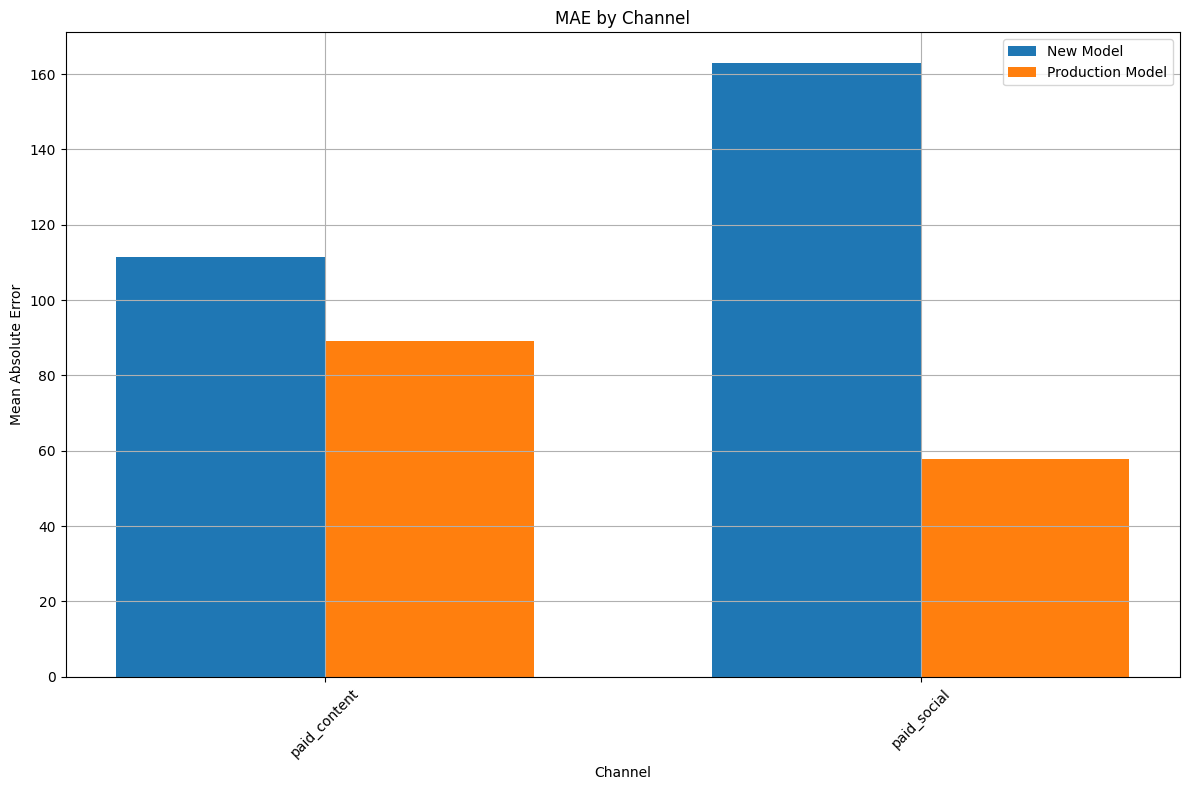


Results saved to CSV files: model_comparison_20250319_103900.csv and channel_metrics_20250319_103900.csv

Snowflake session closed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.snowpark import Session
import config
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connect to Snowflake
def get_snowflake_session():
    connection_parameters = {
        "account": config.SNOWFLAKE_ACCOUNT,
        "user": config.SNOWFLAKE_USER,
        "role": config.SNOWFLAKE_ROLE,
        "warehouse": config.SNOWFLAKE_WAREHOUSE,
        "database": config.SNOWFLAKE_DATABASE,
        "schema": config.SNOWFLAKE_SCHEMA,
        "authenticator": config.SNOWFLAKE_AUTHENTICATOR
    }
    session = Session.builder.configs(connection_parameters).create()
    print(f"Connected to Snowflake as {config.SNOWFLAKE_USER}")
    return session

# Initialize Snowflake session
session = get_snowflake_session()

# Define table names
new_table = "BLINKIST_DEV.DBT_MJAAMA.AGGREGATED_EXPECTED_PROCEEDS_20250320"
prod_table = "BLINKIST_PRODUCTION.REPORTING.MARKETING_SIGNUP_EXP_ROI"

# Step 1: Get the dates available in the new table
print("Fetching available dates from new table...")
dates_query = f"""
SELECT DISTINCT CAST("report_date" AS DATE) AS report_date 
FROM {new_table}
ORDER BY report_date
"""
dates_df = session.sql(dates_query).to_pandas()
available_dates = dates_df['REPORT_DATE'].tolist()
print(f"Found {len(available_dates)} dates in new table: {available_dates}")

# Create date filter for queries - ensure consistent date format
date_filter = ", ".join([f"'{date.strftime('%Y-%m-%d')}'" for date in available_dates])

# Step 2: Fetch data from both tables with matching columns
print("\nFetching data from both tables...")
new_data_query = f"""
SELECT 
    CAST("report_date" AS DATE) AS report_date,
    "channel_group",
    "marketing_network_id",
    "account_id",
    "campaign_name",
    "campaign_id",
    "adgroup_name",
    "adgroup_id",
    "target_market",
    "total_users" AS signups,
    "total_spend" AS eur_marketing_spend,
    "eur_proceeds_d8",
    "expected_proceeds_d8" AS eur_exp_proceeds_d8
FROM {new_table}
WHERE CAST("report_date" AS DATE) IN ({date_filter}) and "total_spend" > 0
"""

prod_data_query = f"""
SELECT 
    CAST(REPORT_DATE AS DATE) AS REPORT_DATE,
    CHANNEL_GROUP,
    MARKETING_NETWORK_ID,
    ACCOUNT_ID,
    CAMPAIGN_NAME,
    CAMPAIGN_ID,
    ADGROUP_NAME,
    ADGROUP_ID,
    TARGET_MARKET,
    SIGNUPS,
    EUR_MARKETING_SPEND,
    EUR_B2C_PROCEEDS_D8 AS EUR_PROCEEDS_D8,
    EUR_EXP_PROCEEDS_D8
FROM {prod_table}
WHERE CAST(REPORT_DATE AS DATE) IN ({date_filter})
AND EUR_EXP_PROCEEDS_D8 IS NOT NULL
"""

new_df = session.sql(new_data_query).to_pandas()
prod_df = session.sql(prod_data_query).to_pandas()

# Convert column names to lowercase for consistency
new_df.columns = new_df.columns.str.lower()
prod_df.columns = prod_df.columns.str.lower()

print(f"Retrieved {len(new_df)} rows from new table")
print(f"Retrieved {len(prod_df)} rows from production table")

# Check if we have data in both dataframes
if len(new_df) == 0 or len(prod_df) == 0:
    print("ERROR: One or both tables have no data for the specified dates.")
    if len(new_df) == 0:
        print("The new table has no data.")
    if len(prod_df) == 0:
        print("The production table has no data.")
    session.close()
    exit()

# Step 3: Create a join key for comparison
join_columns = [
    'report_date', 'adgroup_id'
]

# Check if all join columns exist in both dataframes
missing_in_new = [col for col in join_columns if col not in new_df.columns]
missing_in_prod = [col for col in join_columns if col not in prod_df.columns]

if missing_in_new or missing_in_prod:
    print("ERROR: Some join columns are missing:")
    if missing_in_new:
        print(f"Missing in new table: {missing_in_new}")
    if missing_in_prod:
        print(f"Missing in production table: {missing_in_prod}")
    
    # Use only columns that exist in both dataframes
    join_columns = [col for col in join_columns if col in new_df.columns and col in prod_df.columns]
    print(f"Using reduced join columns: {join_columns}")
    
    if not join_columns:
        print("No common join columns found. Cannot proceed.")
        session.close()
        exit()

# Print sample values from join columns to help diagnose issues
print("\nSample values from join columns:")
for col in join_columns:
    print(f"\n{col} values in new table (first 5):")
    print(new_df[col].head().tolist())
    print(f"{col} values in production table (first 5):")
    print(prod_df[col].head().tolist())

# Ensure report_date is in the same format in both dataframes
print("\nChecking date formats...")
print(f"report_date type in new_df: {new_df['report_date'].dtype}")
print(f"report_date type in prod_df: {prod_df['report_date'].dtype}")

# Convert to datetime if needed
if not pd.api.types.is_datetime64_dtype(new_df['report_date']):
    new_df['report_date'] = pd.to_datetime(new_df['report_date'])
if not pd.api.types.is_datetime64_dtype(prod_df['report_date']):
    prod_df['report_date'] = pd.to_datetime(prod_df['report_date'])

# Create join keys
new_df['join_key'] = new_df[join_columns].astype(str).agg('|'.join, axis=1)
prod_df['join_key'] = prod_df[join_columns].astype(str).agg('|'.join, axis=1)

# Check for common join keys
common_keys = set(new_df['join_key']).intersection(set(prod_df['join_key']))
print(f"\nNumber of common join keys: {len(common_keys)}")

if len(common_keys) == 0:
    print("ERROR: No common join keys found between the tables.")
    print("This could be due to differences in data format or content.")
    
    # Try a more lenient join on fewer columns
    reduced_join_columns = ['report_date', 'channel_group', 'marketing_network_id']
    print(f"\nTrying a more lenient join on: {reduced_join_columns}")
    
    # Check if these columns exist
    if all(col in new_df.columns for col in reduced_join_columns) and all(col in prod_df.columns for col in reduced_join_columns):
        new_df['reduced_join_key'] = new_df[reduced_join_columns].astype(str).agg('|'.join, axis=1)
        prod_df['reduced_join_key'] = prod_df[reduced_join_columns].astype(str).agg('|'.join, axis=1)
        
        common_reduced_keys = set(new_df['reduced_join_key']).intersection(set(prod_df['reduced_join_key']))
        print(f"Number of common keys with reduced join: {len(common_reduced_keys)}")
        
        if len(common_reduced_keys) > 0:
            print("Proceeding with reduced join columns")
            join_columns = reduced_join_columns
            new_df['join_key'] = new_df['reduced_join_key']
            prod_df['join_key'] = prod_df['reduced_join_key']
        else:
            print("Still no common keys found. Cannot proceed with comparison.")
            session.close()
            exit()
    else:
        print("Cannot use reduced join columns. Exiting.")
        session.close()
        exit()

# Step 4: Merge datasets on join key
merged_df = pd.merge(
    new_df, 
    prod_df, 
    on='join_key', 
    how='inner',  # Only keep rows present in both tables
    suffixes=('_new', '_prod')
)

print(f"Common rows in both tables after merge: {len(merged_df)}")

if len(merged_df) == 0:
    print("ERROR: No common rows found after merging. Cannot proceed with comparison.")
    session.close()
    exit()

# Check for NaN values in key columns
print("\nChecking for NaN values in key columns:")
print(f"NaN values in eur_proceeds_d8_new: {merged_df['eur_proceeds_d8_new'].isna().sum()}")
print(f"NaN values in eur_exp_proceeds_d8_new: {merged_df['eur_exp_proceeds_d8_new'].isna().sum()}")
print(f"NaN values in eur_proceeds_d8_prod: {merged_df['eur_proceeds_d8_prod'].isna().sum()}")
print(f"NaN values in eur_exp_proceeds_d8_prod: {merged_df['eur_exp_proceeds_d8_prod'].isna().sum()}")

# Drop rows with NaN values in key columns
merged_df_clean = merged_df.dropna(subset=['eur_proceeds_d8_new', 'eur_exp_proceeds_d8_new', 
                                          'eur_proceeds_d8_prod', 'eur_exp_proceeds_d8_prod'])
print(f"Rows before cleaning: {len(merged_df)}, after cleaning: {len(merged_df_clean)}")

# Set small predicted proceeds to zero
merged_df_clean['eur_exp_proceeds_d8_new'] = np.where(merged_df_clean['eur_exp_proceeds_d8_new'] < 1, 0, merged_df_clean['eur_exp_proceeds_d8_new'])
merged_df_clean['eur_exp_proceeds_d8_prod'] = np.where(merged_df_clean['eur_exp_proceeds_d8_prod'] < 1, 0, merged_df_clean['eur_exp_proceeds_d8_prod'])

# Continue with the rest of the script only if we have data to compare
# Step 5: Verify actuals are the same
print("\nVerifying actuals between tables...")
actuals_columns = [
    ('eur_proceeds_d8_new', 'eur_proceeds_d8_prod'),
    ('eur_marketing_spend_new', 'eur_marketing_spend_prod'),
    ('signups_new', 'signups_prod')
]

for new_col, prod_col in actuals_columns:
    if new_col in merged_df_clean.columns and prod_col in merged_df_clean.columns:
        # Calculate absolute difference
        merged_df_clean['diff'] = (merged_df_clean[new_col] - merged_df_clean[prod_col]).abs()
        
        # Calculate relative difference (percentage)
        merged_df_clean['rel_diff'] = np.where(
            merged_df_clean[prod_col] != 0,
            (merged_df_clean['diff'] / merged_df_clean[prod_col].abs()) * 100,
            np.where(merged_df_clean[new_col] != 0, 100, 0)
        )
        
        # Set a threshold for significant differences (e.g., 1%)
        threshold = 1.0
        significant_diff = merged_df_clean[merged_df_clean['rel_diff'] > threshold]
        
        mean_diff = merged_df_clean['diff'].mean()
        max_diff = merged_df_clean['diff'].max()
        
        print(f"\n{new_col.replace('_new', '')} vs {prod_col.replace('_prod', '')}:")
        print(f"  Mean absolute difference: {mean_diff:.4f}")
        print(f"  Max absolute difference: {max_diff:.4f}")
        print(f"  Rows with >1% difference: {len(significant_diff)} ({len(significant_diff)/len(merged_df_clean)*100:.2f}%)")
    else:
        print(f"Columns {new_col} and/or {prod_col} not found in merged dataframe")

# Step 6: Compare prediction accuracy against actual values
print("\nComparing prediction accuracy against actual values...")

# Use a single actual value column to avoid confusion
merged_df_clean['actual_proceeds_d8'] = merged_df_clean['eur_proceeds_d8_new']

# Calculate absolute error for each model
merged_df_clean['abs_error_new'] = (merged_df_clean['eur_exp_proceeds_d8_new'] - merged_df_clean['actual_proceeds_d8']).abs()
merged_df_clean['abs_error_prod'] = (merged_df_clean['eur_exp_proceeds_d8_prod'] - merged_df_clean['actual_proceeds_d8']).abs()

# Calculate percentage error for each model (avoiding division by zero)
merged_df_clean['pct_error_new'] = np.where(
    merged_df_clean['actual_proceeds_d8'] != 0,
    (merged_df_clean['abs_error_new'] / merged_df_clean['actual_proceeds_d8']) * 100,
    np.where(merged_df_clean['eur_exp_proceeds_d8_new'] != 0, 100, 0)
)

merged_df_clean['pct_error_prod'] = np.where(
    merged_df_clean['actual_proceeds_d8'] != 0,
    (merged_df_clean['abs_error_prod'] / merged_df_clean['actual_proceeds_d8']) * 100,
    np.where(merged_df_clean['eur_exp_proceeds_d8_prod'] != 0, 100, 0)
)

# Calculate which model is better for each row
merged_df_clean['better_model'] = np.where(
    merged_df_clean['abs_error_new'] < merged_df_clean['abs_error_prod'], 
    'new', 
    np.where(
        merged_df_clean['abs_error_new'] > merged_df_clean['abs_error_prod'],
        'production',
        'equal'
    )
)

# Calculate overall metrics
mae_new = mean_absolute_error(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_new'])
mae_prod = mean_absolute_error(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_prod'])

rmse_new = np.sqrt(mean_squared_error(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_new']))
rmse_prod = np.sqrt(mean_squared_error(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_prod']))

r2_new = r2_score(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_new'])
r2_prod = r2_score(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_prod'])

# Calculate mean percentage error
mape_new = merged_df_clean['pct_error_new'].mean()
mape_prod = merged_df_clean['pct_error_prod'].mean()

# Count how many times each model is better
better_counts = merged_df_clean['better_model'].value_counts()

print("\nOverall Error Metrics:")
print(f"Mean Absolute Error (MAE):")
print(f"  New model: {mae_new:.4f}")
print(f"  Production model: {mae_prod:.4f}")
print(f"  Improvement: {(1 - mae_new/mae_prod)*100:.2f}%")

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  New model: {rmse_new:.4f}")
print(f"  Production model: {rmse_prod:.4f}")
print(f"  Improvement: {(1 - rmse_new/rmse_prod)*100:.2f}%")

print(f"\nMean Absolute Percentage Error (MAPE):")
print(f"  New model: {mape_new:.2f}%")
print(f"  Production model: {mape_prod:.2f}%")
print(f"  Improvement: {(1 - mape_new/mape_prod)*100:.2f}%")

print(f"\nR² Score:")
print(f"  New model: {r2_new:.4f}")
print(f"  Production model: {r2_prod:.4f}")
print(f"  Difference: {r2_new - r2_prod:.4f}")

print("\nBetter Model Counts:")
for model, count in better_counts.items():
    print(f"  {model.capitalize()}: {count} rows ({count/len(merged_df_clean)*100:.2f}%)")

# Step 7: Analyze by channel_group
    
# Analyze by channel_group
print("\nAnalyzing by channel_group:")
channel_metrics = []

for channel in agg_df['channel_group_new'].unique():
    channel_data = agg_df[agg_df['channel_group_new'] == channel]
    
    if len(channel_data) == 0:
        continue
    
    channel_mae_new = mean_absolute_error(channel_data['eur_proceeds_d8_new'], channel_data['eur_exp_proceeds_d8_new'])
    channel_mae_prod = mean_absolute_error(channel_data['eur_proceeds_d8_prod'], channel_data['eur_exp_proceeds_d8_prod'])
    channel_mape_new = channel_data['pct_error_new'].mean()
    channel_mape_prod = channel_data['pct_error_prod'].mean()
    
    # Calculate improvements safely
    mae_improvement = (1 - channel_mae_new/channel_mae_prod)*100 if channel_mae_prod != 0 else float('inf') if channel_mae_new == 0 else float('-inf')
    mape_improvement = (1 - channel_mape_new/channel_mape_prod)*100 if channel_mape_prod != 0 else float('inf') if channel_mape_new == 0 else float('-inf')
    
    # Count better model for this channel
    channel_better = channel_data['better_model'].value_counts()
    new_better_pct = channel_better.get('new', 0) / len(channel_data) * 100
    
    channel_metrics.append({
        'Channel': channel,
        'Count': len(channel_data),
        'MAE New': channel_mae_new,
        'MAE Prod': channel_mae_prod,
        'MAE Improvement %': mae_improvement,
        'MAPE New %': channel_mape_new,
        'MAPE Prod %': channel_mape_prod,
        'MAPE Improvement %': mape_improvement,
        'New Better %': new_better_pct
    })
    
    print(f"\nChannel: {channel} ({len(channel_data)} rows)")
    print(f"  MAE: New={channel_mae_new:.4f}, Prod={channel_mae_prod:.4f}")
    
    # Print improvements with appropriate handling of special cases
    if channel_mae_prod == 0:
        if channel_mae_new == 0:
            print("  MAE Improvement: Both models perfect (0 error)")
        else:
            print("  MAE Improvement: Cannot calculate (production model has 0 error)")
    else:
        print(f"  MAE Improvement: {mae_improvement:.2f}%")
    
    print(f"  MAPE: New={channel_mape_new:.2f}%, Prod={channel_mape_prod:.2f}%")
    if channel_mape_prod == 0:
        if channel_mape_new == 0:
            print("  MAPE Improvement: Both models perfect (0 error)")
        else:
            print("  MAPE Improvement: Cannot calculate (production model has 0 error)")
    else:
        print(f"  MAPE Improvement: {mape_improvement:.2f}%")
    
    print(f"  New model better: {new_better_pct:.2f}% of rows")

# Create channel metrics dataframe
channel_metrics_df = pd.DataFrame(channel_metrics)
channel_metrics_df = channel_metrics_df.sort_values('Count', ascending=False)

print("\nChannel Metrics Summary:")
display(channel_metrics_df)

# Step 8: Visualize the comparison
print("\nCreating visualizations...")

# Scatter plot of actual vs predicted for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_new'], alpha=0.5)
plt.plot([0, merged_df_clean['actual_proceeds_d8'].max()], [0, merged_df_clean['actual_proceeds_d8'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('New Model Predicted Proceeds D8')
plt.title('New Model: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(merged_df_clean['actual_proceeds_d8'], merged_df_clean['eur_exp_proceeds_d8_prod'], alpha=0.5)
plt.plot([0, merged_df_clean['actual_proceeds_d8'].max()], [0, merged_df_clean['actual_proceeds_d8'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('Production Model Predicted Proceeds D8')
plt.title('Production Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# Histogram of absolute errors for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(merged_df_clean['abs_error_new'].clip(0, merged_df_clean['abs_error_new'].quantile(0.95)), bins=50)
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.title('New Model: Distribution of Absolute Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(merged_df_clean['abs_error_prod'].clip(0, merged_df_clean['abs_error_prod'].quantile(0.95)), bins=50)
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.title('Production Model: Distribution of Absolute Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

# Histogram of percentage errors for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(merged_df_clean['pct_error_new'].clip(0, 100), bins=50)
plt.xlabel('Percentage Error')
plt.ylabel('Count')
plt.title('New Model: Distribution of Percentage Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(merged_df_clean['pct_error_prod'].clip(0, 100), bins=50)
plt.xlabel('Percentage Error')
plt.ylabel('Count')
plt.title('Production Model: Distribution of Percentage Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar chart of channel performance
plt.figure(figsize=(12, 8))
channels = channel_metrics_df['Channel'].tolist()
new_mae = channel_metrics_df['MAE New'].tolist()
prod_mae = channel_metrics_df['MAE Prod'].tolist()

x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, new_mae, width, label='New Model')
plt.bar(x + width/2, prod_mae, width, label='Production Model')

plt.xlabel('Channel')
plt.ylabel('Mean Absolute Error')
plt.title('MAE by Channel')
plt.xticks(x, channels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Save results to CSV for further analysis
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
merged_df_clean.to_csv(f"model_comparison_{timestamp}.csv", index=False)
channel_metrics_df.to_csv(f"channel_metrics_{timestamp}.csv", index=False)

print(f"\nResults saved to CSV files: model_comparison_{timestamp}.csv and channel_metrics_{timestamp}.csv")

# Close Snowflake session
session.close()
print("\nSnowflake session closed")

In [31]:
# Calculate absolute difference and relative difference
merged_df_clean['proceeds_diff'] = (merged_df_clean['eur_proceeds_d8_new'] - merged_df_clean['eur_proceeds_d8_prod']).abs()
merged_df_clean['proceeds_rel_diff'] = np.where(
    merged_df_clean['eur_proceeds_d8_prod'] != 0,
    (merged_df_clean['proceeds_diff'] / merged_df_clean['eur_proceeds_d8_prod'].abs()) * 100,
    np.where(merged_df_clean['eur_proceeds_d8_new'] != 0, 100, 0)
)

# Filter rows with >1% difference
significant_diff = merged_df_clean[merged_df_clean['proceeds_rel_diff'] > 1].copy()

print(f"Total rows analyzed: {len(merged_df_clean)}")
print(f"Rows with >1% difference: {len(significant_diff)} ({len(significant_diff)/len(merged_df_clean)*100:.2f}%)")

# Basic statistics of the differences
print("\nStatistics of differences where >1%:")
print(significant_diff[['proceeds_diff', 'proceeds_rel_diff']].describe())

# Group by channel and analyze
channel_analysis = significant_diff.groupby('channel_group_new').agg({
    'proceeds_diff': ['count', 'mean', 'median', 'std'],
    'proceeds_rel_diff': ['mean', 'median', 'std']
}).round(2)

print("\nAnalysis by channel:")
display(channel_analysis)

# Sample of differences
print("\nSample of 10 rows with largest relative differences:")
columns_to_show = [
    'report_date', 'channel_group_new', 'marketing_network_id_new', 
    'campaign_name_new', 'adgroup_name_new',
    'eur_proceeds_d8_new', 'eur_proceeds_d8_prod', 
    'proceeds_diff', 'proceeds_rel_diff'
]
display(significant_diff.nlargest(10, 'proceeds_rel_diff')[columns_to_show])

# Distribution of differences
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(significant_diff['proceeds_diff'].clip(0, significant_diff['proceeds_diff'].quantile(0.95)), bins=50)
plt.title('Distribution of Absolute Differences')
plt.xlabel('Absolute Difference (EUR)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(significant_diff['proceeds_rel_diff'].clip(0, 100), bins=50)
plt.title('Distribution of Relative Differences')
plt.xlabel('Relative Difference (%)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Time series analysis
significant_diff['report_date'] = pd.to_datetime(significant_diff['report_date'])
daily_stats = significant_diff.groupby('report_date').agg({
    'proceeds_diff': ['count', 'mean', 'median'],
    'proceeds_rel_diff': ['mean', 'median']
}).round(2)

plt.figure(figsize=(15, 6))
plt.plot(daily_stats.index, daily_stats[('proceeds_diff', 'count')], marker='o')
plt.title('Number of Differences >1% Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the analysis
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
significant_diff.to_csv(f'proceeds_differences_{timestamp}.csv', index=False)
daily_stats.to_csv(f'daily_difference_stats_{timestamp}.csv')

# Additional analysis: Distribution of differences by marketing network
network_analysis = significant_diff.groupby('marketing_network_id_new').agg({
    'proceeds_diff': ['count', 'mean', 'median', 'std'],
    'proceeds_rel_diff': ['mean', 'median', 'std']
}).round(2)

print("\nAnalysis by marketing network:")
display(network_analysis)

# Boxplot of differences by channel
plt.figure(figsize=(15, 6))
sns.boxplot(data=significant_diff, x='channel_group_new', y='proceeds_rel_diff', whis=1.5)
plt.title('Distribution of Relative Differences by Channel')
plt.xticks(rotation=45)
plt.ylabel('Relative Difference (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

Total rows analyzed: 610
Rows with >1% difference: 47 (7.70%)

Statistics of differences where >1%:
       proceeds_diff  proceeds_rel_diff
count      47.000000          47.000000
mean      117.015210          97.395488
std       110.954493          15.882674
min         0.236437          21.721269
25%        48.722597         100.000000
50%        82.192254         100.000000
75%       139.159754         100.000000
max       503.567566         142.634533

Analysis by channel:


proceeds_diff                         proceeds_rel_diff  \
                          count    mean  median     std              mean   
channel_group_new                                                           
paid_content                 45  115.48   82.19  111.35             97.28   
paid_social                   2  151.47  151.47  135.23            100.00   

                                 
                  median    std  
channel_group_new                
paid_content       100.0  16.23  
paid_social        100.0   0.00


Sample of 10 rows with largest relative differences:


KeyError: "['report_date'] not in index"

In [32]:
significant_diff.head(10)

,report_date_new,channel_group_new,marketing_network_id_new,account_id_new,campaign_name_new,campaign_id_new,adgroup_name_new,adgroup_id_new,target_market_new,signups_new,...,pct_error_prod,better_model,actual_roi,actual_winner,pred_roi_new,pred_winner_new,pred_roi_prod,pred_winner_prod,proceeds_diff,proceeds_rel_diff
11,2025-01-21,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,51,...,100.000000,new,NaN,False,NaN,False,NaN,False,263.213868,100.0
14,2025-01-21,paid_content,facebook,927736373941355,20241111_FB_PRO_DACH_Web2App_ALL_S2S_MAN_MNC_S...,6620397940259,20250107_FB_PRO_DACH_Web2App_ALL_S2S_MAN_MNC_S...,6633814412059,dach,41,...,92.763119,new,NaN,False,NaN,False,NaN,False,322.838277,100.0
34,2025-01-22,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,40,...,100.000000,new,NaN,False,NaN,False,NaN,False,170.188040,100.0
53,2025-01-23,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,31,...,100.000000,new,NaN,False,NaN,False,NaN,False,87.887881,100.0
69,2025-01-24,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250114_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6636318214259,row,26,...,100.000000,new,NaN,False,NaN,False,NaN,False,246.206084,100.0
89,2025-01-25,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,35,...,100.000000,new,NaN,False,NaN,False,NaN,False,356.921221,100.0
106,2025-01-26,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,32,...,100.000000,new,NaN,False,NaN,False,NaN,False,503.567566,100.0
114,2025-01-26,paid_content,facebook,927736373941355,20250116_FB_PRO_US-ENG-T1_Web2App_ALL_S2S_MAN_...,6637126958459,20250122_FB_PRO_US-ENG-T1_Web2App_ALL_S2S_MAN_...,6642474549659,row,21,...,100.000000,new,NaN,False,NaN,False,NaN,False,55.466534,100.0
120,2025-01-27,paid_content,facebook,927736373941355,20240712_FB_PRO_US_Web2App_iOS_S2S_MAN_MNC_Sub...,6596545486259,20250114_FB_PRO_US_Web2App_ALL_S2S_MAN_MNC_Sub...,6636314086459,us,7,...,100.000000,new,-1.00049,False,-0.937638,False,-0.531133,True,0.236437,100.0
124,2025-01-27,paid_content,facebook,927736373941355,20240830_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6606006704259,20250118_FB_PRO_ROW_Web2App_ALL_S2S_MAN_MNC_Su...,6638407703459,row,25,...,100.000000,new,NaN,False,NaN,False,NaN,False,88.929741,100.0


Winner/Loser Distribution in Actual Data:
Winners: 29.3%
Losers: 70.7%

New Model Classification Metrics:
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       431
        True       0.89      0.88      0.89       179

    accuracy                           0.93       610
   macro avg       0.92      0.92      0.92       610
weighted avg       0.93      0.93      0.93       610


Production Model Classification Metrics:
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       431
        True       0.89      0.89      0.89       179

    accuracy                           0.94       610
   macro avg       0.92      0.92      0.92       610
weighted avg       0.94      0.94      0.94       610



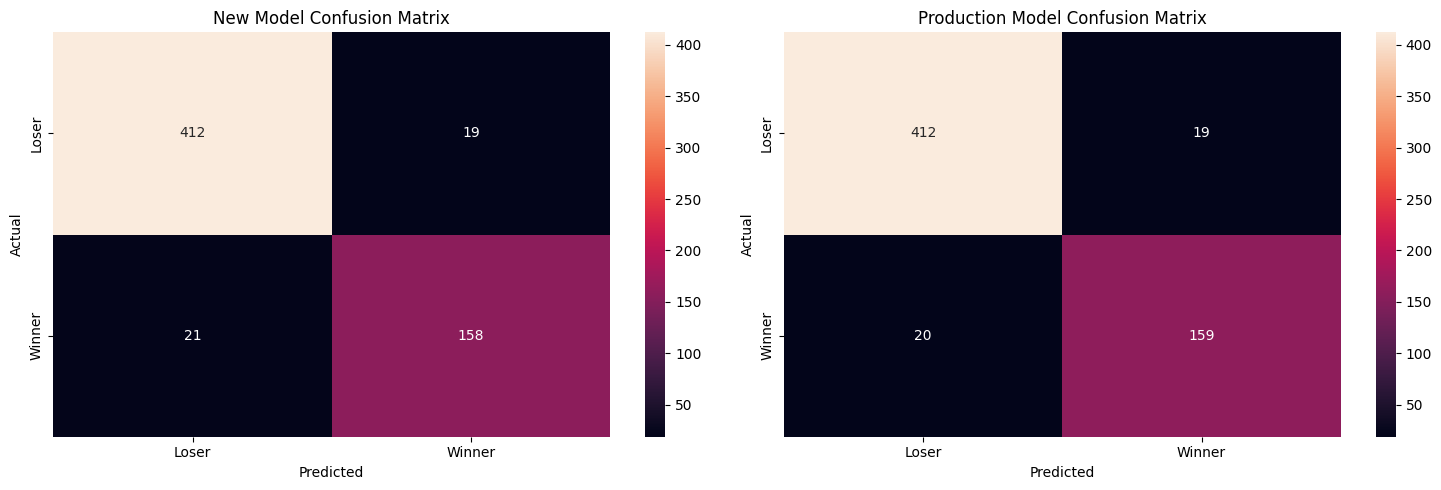


Winner/Loser Prediction Accuracy by Channel:

Channel: paid_content
Number of daily ad records: 573
Winners: 28.3%
New Model Accuracy: 93.2%
Production Model Accuracy: 93.4%
Accuracy Improvement: -0.2%

Channel: paid_social
Number of daily ad records: 37
Winners: 45.9%
New Model Accuracy: 97.3%
Production Model Accuracy: 97.3%
Accuracy Improvement: 0.0%

Channel Results Summary:


,Channel,Count,Winners %,New Model Accuracy,Prod Model Accuracy,Accuracy Improvement
0,paid_content,573,28.272251,93.193717,93.368237,-0.17452
1,paid_social,37,45.945946,97.297297,97.297297,0.00000


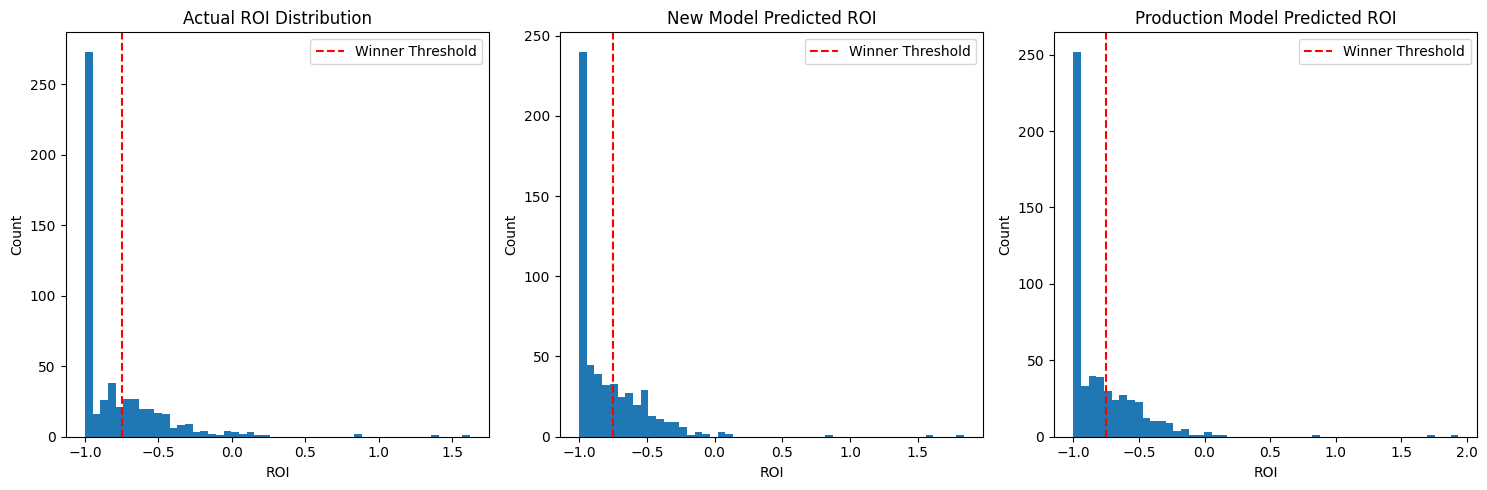

KeyError: 'report_date'

In [30]:
# Calculate ROI and winner/loser status for actual data
merged_df_clean['actual_roi'] = (merged_df_clean['eur_proceeds_d8_prod'] / merged_df_clean['eur_marketing_spend_prod'].replace(0, np.nan)) - 1
merged_df_clean['actual_winner'] = merged_df_clean['actual_roi'] > -0.75

# Calculate ROI and winner/loser predictions for both models
merged_df_clean['pred_roi_new'] = (merged_df_clean['eur_exp_proceeds_d8_new'] / merged_df_clean['eur_marketing_spend_prod'].replace(0, np.nan)) - 1
merged_df_clean['pred_winner_new'] = merged_df_clean['pred_roi_new'] > -0.75

merged_df_clean['pred_roi_prod'] = (merged_df_clean['eur_exp_proceeds_d8_prod'] / merged_df_clean['eur_marketing_spend_prod'].replace(0, np.nan)) - 1
merged_df_clean['pred_winner_prod'] = merged_df_clean['pred_roi_prod'] > -0.75

# Show winner/loser distribution in the data
print("Winner/Loser Distribution in Actual Data:")
winner_dist = merged_df_clean['actual_winner'].value_counts(normalize=True) * 100
print(f"Winners: {winner_dist[True]:.1f}%")
print(f"Losers: {winner_dist[False]:.1f}%")

# Calculate prediction accuracy for both models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nNew Model Classification Metrics:")
print(classification_report(merged_df_clean['actual_winner'], merged_df_clean['pred_winner_new']))

print("\nProduction Model Classification Metrics:")
print(classification_report(merged_df_clean['actual_winner'], merged_df_clean['pred_winner_prod']))

# Create confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# New Model Confusion Matrix
cm_new = confusion_matrix(merged_df_clean['actual_winner'], merged_df_clean['pred_winner_new'])
sns.heatmap(cm_new, annot=True, fmt='d', ax=ax1)
ax1.set_title('New Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['Loser', 'Winner'])
ax1.set_yticklabels(['Loser', 'Winner'])

# Production Model Confusion Matrix
cm_prod = confusion_matrix(merged_df_clean['actual_winner'], merged_df_clean['pred_winner_prod'])
sns.heatmap(cm_prod, annot=True, fmt='d', ax=ax2)
ax2.set_title('Production Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['Loser', 'Winner'])
ax2.set_yticklabels(['Loser', 'Winner'])

plt.tight_layout()
plt.show()

# Analyze by channel
print("\nWinner/Loser Prediction Accuracy by Channel:")
channel_results = []

for channel in merged_df_clean['channel_group_new'].unique():
    channel_data = merged_df_clean[merged_df_clean['channel_group_new'] == channel]
    
    if len(channel_data) == 0:
        continue
        
    acc_new = accuracy_score(channel_data['actual_winner'], channel_data['pred_winner_new'])
    acc_prod = accuracy_score(channel_data['actual_winner'], channel_data['pred_winner_prod'])
    
    # Calculate winner percentage in this channel
    winner_pct = (channel_data['actual_winner'] == True).mean() * 100
    
    channel_results.append({
        'Channel': channel,
        'Count': len(channel_data),
        'Winners %': winner_pct,
        'New Model Accuracy': acc_new * 100,
        'Prod Model Accuracy': acc_prod * 100,
        'Accuracy Improvement': (acc_new - acc_prod) * 100
    })
    
    print(f"\nChannel: {channel}")
    print(f"Number of daily ad records: {len(channel_data)}")
    print(f"Winners: {winner_pct:.1f}%")
    print(f"New Model Accuracy: {acc_new:.1%}")
    print(f"Production Model Accuracy: {acc_prod:.1%}")
    print(f"Accuracy Improvement: {(acc_new - acc_prod):.1%}")

# Create channel results dataframe
channel_results_df = pd.DataFrame(channel_results)
channel_results_df = channel_results_df.sort_values('Count', ascending=False)

print("\nChannel Results Summary:")
display(channel_results_df)

# Visualize ROI distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(merged_df_clean['actual_roi'].clip(-2, 2), bins=50)
plt.title('Actual ROI Distribution')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(merged_df_clean['pred_roi_new'].clip(-2, 2), bins=50)
plt.title('New Model Predicted ROI')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(merged_df_clean['pred_roi_prod'].clip(-2, 2), bins=50)
plt.title('Production Model Predicted ROI')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Additional analysis: Day-by-day accuracy
merged_df_clean['date'] = pd.to_datetime(merged_df_clean['report_date'])
daily_accuracy = merged_df_clean.groupby('date').apply(
    lambda x: pd.Series({
        'new_accuracy': accuracy_score(x['actual_winner'], x['pred_winner_new']),
        'prod_accuracy': accuracy_score(x['actual_winner'], x['pred_winner_prod']),
        'n_ads': len(x)
    })
).reset_index()

# Plot daily accuracy
plt.figure(figsize=(15, 6))
plt.plot(daily_accuracy['date'], daily_accuracy['new_accuracy'], label='New Model', marker='o')
plt.plot(daily_accuracy['date'], daily_accuracy['prod_accuracy'], label='Production Model', marker='o')
plt.title('Daily Winner/Loser Prediction Accuracy')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save results
merged_df_clean.to_csv('daily_winner_loser_analysis.csv', index=False)
channel_results_df.to_csv('daily_winner_loser_channel_analysis.csv', index=False)
daily_accuracy.to_csv('daily_accuracy.csv', index=False)

In [19]:
merged_df_clean.to_csv('comparison2.csv')

In [26]:
# Calculate ROI and winner/loser status for actual data
agg_df['actual_roi'] = (agg_df['eur_proceeds_d8_new'] / agg_df['eur_marketing_spend_new'].replace(0, np.nan)) - 1
agg_df['actual_winner'] = agg_df['actual_roi'] > -0.75

# Calculate ROI and winner/loser predictions for both models
agg_df['pred_roi_new'] = (agg_df['eur_exp_proceeds_d8_new'] / agg_df['eur_marketing_spend_new'].replace(0, np.nan)) - 1
agg_df['pred_winner_new'] = agg_df['pred_roi_new'] > -0.75

agg_df['pred_roi_prod'] = (agg_df['eur_exp_proceeds_d8_prod'] / agg_df['eur_marketing_spend_prod'].replace(0, np.nan)) - 1
agg_df['pred_winner_prod'] = agg_df['pred_roi_prod'] > -0.75

# Show winner/loser distribution in the data
print("Winner/Loser Distribution in Actual Data:")
winner_dist = agg_df['actual_winner'].value_counts(normalize=True) * 100
print(f"Winners: {winner_dist[True]:.1f}%")
print(f"Losers: {winner_dist[False]:.1f}%")

# Calculate prediction accuracy for both models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nNew Model Classification Metrics:")
print(classification_report(agg_df['actual_winner'], agg_df['pred_winner_new']))

print("\nProduction Model Classification Metrics:")
print(classification_report(agg_df['actual_winner'], agg_df['pred_winner_prod']))

# Create confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# New Model Confusion Matrix
cm_new = confusion_matrix(agg_df['actual_winner'], agg_df['pred_winner_new'])
sns.heatmap(cm_new, annot=True, fmt='d', ax=ax1)
ax1.set_title('New Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['Loser', 'Winner'])
ax1.set_yticklabels(['Loser', 'Winner'])

# Production Model Confusion Matrix
cm_prod = confusion_matrix(agg_df['actual_winner'], agg_df['pred_winner_prod'])
sns.heatmap(cm_prod, annot=True, fmt='d', ax=ax2)
ax2.set_title('Production Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['Loser', 'Winner'])
ax2.set_yticklabels(['Loser', 'Winner'])

plt.tight_layout()
plt.show()

# Analyze by channel
print("\nWinner/Loser Prediction Accuracy by Channel:")
channel_results = []

for channel in agg_df['channel_group_new'].unique():
    channel_data = agg_df[agg_df['channel_group_new'] == channel]
    
    if len(channel_data) == 0:
        continue
        
    acc_new = accuracy_score(channel_data['actual_winner'], channel_data['pred_winner_new'])
    acc_prod = accuracy_score(channel_data['actual_winner'], channel_data['pred_winner_prod'])
    
    # Calculate winner percentage in this channel
    winner_pct = (channel_data['actual_winner'] == True).mean() * 100
    
    channel_results.append({
        'Channel': channel,
        'Count': len(channel_data),
        'Winners %': winner_pct,
        'New Model Accuracy': acc_new * 100,
        'Prod Model Accuracy': acc_prod * 100,
        'Accuracy Improvement': (acc_new - acc_prod) * 100
    })
    
    print(f"\nChannel: {channel}")
    print(f"Number of ads: {len(channel_data)}")
    print(f"Winners: {winner_pct:.1f}%")
    print(f"New Model Accuracy: {acc_new:.1%}")
    print(f"Production Model Accuracy: {acc_prod:.1%}")
    print(f"Accuracy Improvement: {(acc_new - acc_prod):.1%}")

# Create channel results dataframe
channel_results_df = pd.DataFrame(channel_results)
channel_results_df = channel_results_df.sort_values('Count', ascending=False)

print("\nChannel Results Summary:")
display(channel_results_df)

# Visualize ROI distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(agg_df['actual_roi'].clip(-2, 2), bins=50)
plt.title('Actual ROI Distribution')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(agg_df['pred_roi_new'].clip(-2, 2), bins=50)
plt.title('New Model Predicted ROI')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(agg_df['pred_roi_prod'].clip(-2, 2), bins=50)
plt.title('Production Model Predicted ROI')
plt.xlabel('ROI')
plt.ylabel('Count')
plt.axvline(-0.75, color='r', linestyle='--', label='Winner Threshold')
plt.legend()

plt.tight_layout()
plt.show()

# Save results
agg_df.to_csv('winner_loser_analysis.csv', index=False)
channel_results_df.to_csv('winner_loser_channel_analysis.csv', index=False)

KeyError: 'eur_marketing_spend_new'

Number of unique adgroups: 117

Aggregated Error Metrics:
Mean Absolute Error (MAE):
  New model: 113.7368
  Production model: 87.7371
  Improvement: -29.63%

Root Mean Squared Error (RMSE):
  New model: 246.6259
  Production model: 159.9338
  Improvement: -54.20%

Mean Absolute Percentage Error (MAPE):
  New model: 20.72%
  Production model: 19.76%
  Improvement: -4.86%

R² Score:
  New model: 0.9980
  Production model: 0.9989
  Difference: -0.0009

Better Model Counts:
  Production: 58 adgroups (49.57%)
  New: 41 adgroups (35.04%)
  Equal: 18 adgroups (15.38%)

Analyzing by channel_group:

Channel Metrics Summary:


,Channel,Count,MAE New,MAE Prod,MAE Improvement %,MAPE New %,MAPE Prod %,MAPE Improvement %,New Better %
0,paid_content,112,111.540228,89.071632,-25.225311,20.472935,19.643861,-4.220522,36.607143
1,paid_social,5,162.940978,57.842934,-181.695560,26.332442,22.441317,-17.339113,0.000000


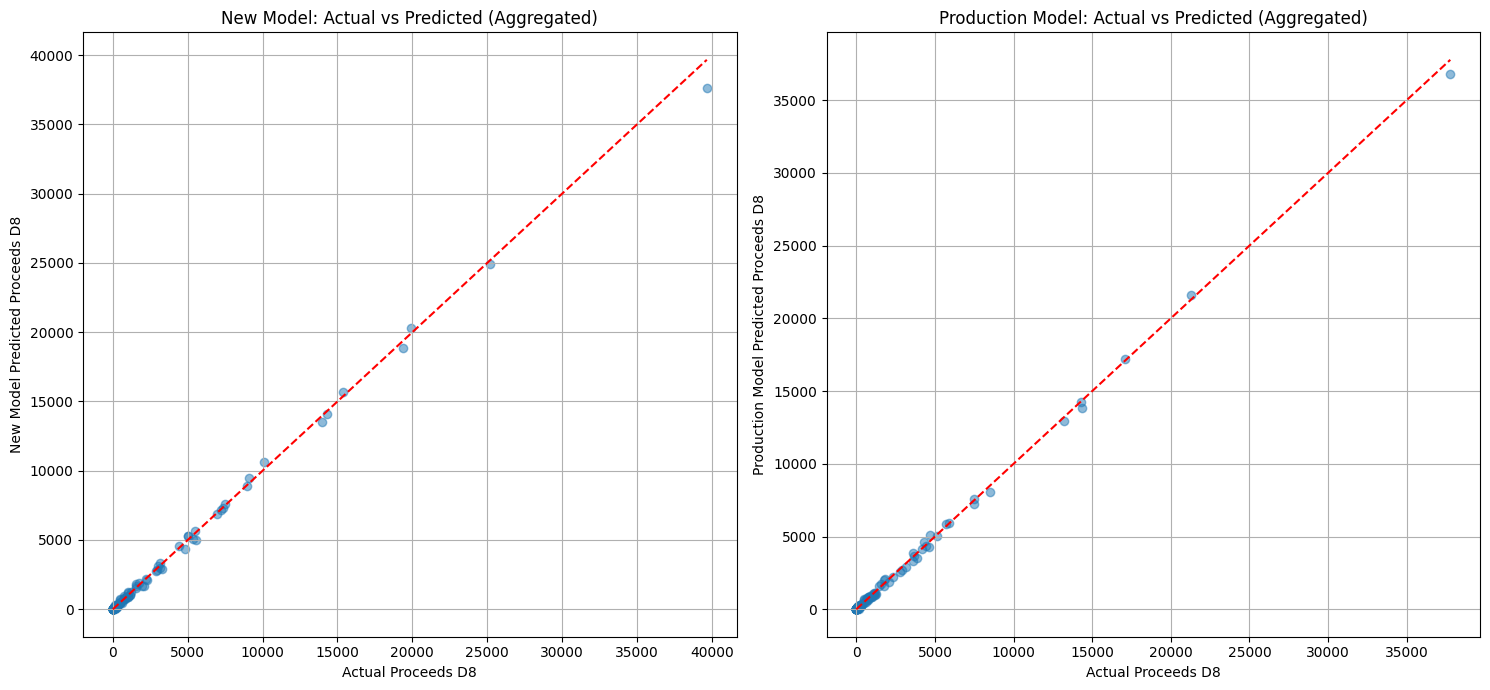


Results saved to CSV files: aggregated_comparison_20250319_093603.csv and aggregated_channel_metrics_20250319_093603.csv


In [25]:
# Aggregate data by adgroup_id
agg_df = merged_df_clean.groupby('adgroup_id_new').agg({
    'eur_proceeds_d8_new': 'sum',
    'eur_exp_proceeds_d8_new': 'sum',
    'eur_proceeds_d8_prod': 'sum',
    'eur_exp_proceeds_d8_prod': 'sum',
    'channel_group_new': 'first',  # Keep channel group for reference
    'marketing_network_id_new': 'first'  # Keep network for reference
}).reset_index()

# Calculate error metrics for aggregated data
agg_df['abs_error_new'] = (agg_df['eur_exp_proceeds_d8_new'] - agg_df['eur_proceeds_d8_new']).abs()
agg_df['abs_error_prod'] = (agg_df['eur_exp_proceeds_d8_prod'] - agg_df['eur_proceeds_d8_prod']).abs()

# Calculate percentage errors (avoiding division by zero)
agg_df['pct_error_new'] = np.where(
    agg_df['eur_proceeds_d8_new'] != 0,
    (agg_df['abs_error_new'] / agg_df['eur_proceeds_d8_new']) * 100,
    np.where(agg_df['eur_exp_proceeds_d8_new'] != 0, 100, 0)
)

agg_df['pct_error_prod'] = np.where(
    agg_df['eur_proceeds_d8_prod'] != 0,
    (agg_df['abs_error_prod'] / agg_df['eur_proceeds_d8_prod']) * 100,
    np.where(agg_df['eur_exp_proceeds_d8_prod'] != 0, 100, 0)
)

# Calculate which model is better
agg_df['better_model'] = np.where(
    agg_df['abs_error_new'] < agg_df['abs_error_prod'], 
    'new', 
    np.where(
        agg_df['abs_error_new'] > agg_df['abs_error_prod'],
        'production',
        'equal'
    )
)

# Calculate overall metrics
mae_new = mean_absolute_error(agg_df['eur_proceeds_d8_new'], agg_df['eur_exp_proceeds_d8_new'])
mae_prod = mean_absolute_error(agg_df['eur_proceeds_d8_prod'], agg_df['eur_exp_proceeds_d8_prod'])
rmse_new = np.sqrt(mean_squared_error(agg_df['eur_proceeds_d8_new'], agg_df['eur_exp_proceeds_d8_new']))
rmse_prod = np.sqrt(mean_squared_error(agg_df['eur_proceeds_d8_prod'], agg_df['eur_exp_proceeds_d8_prod']))
r2_new = r2_score(agg_df['eur_proceeds_d8_new'], agg_df['eur_exp_proceeds_d8_new'])
r2_prod = r2_score(agg_df['eur_proceeds_d8_prod'], agg_df['eur_exp_proceeds_d8_prod'])
mape_new = agg_df['pct_error_new'].mean()
mape_prod = agg_df['pct_error_prod'].mean()

print(f"Number of unique adgroups: {len(agg_df)}")

print("\nAggregated Error Metrics:")
print(f"Mean Absolute Error (MAE):")
print(f"  New model: {mae_new:.4f}")
print(f"  Production model: {mae_prod:.4f}")
print(f"  Improvement: {(1 - mae_new/mae_prod)*100:.2f}%")

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  New model: {rmse_new:.4f}")
print(f"  Production model: {rmse_prod:.4f}")
print(f"  Improvement: {(1 - rmse_new/rmse_prod)*100:.2f}%")

print(f"\nMean Absolute Percentage Error (MAPE):")
print(f"  New model: {mape_new:.2f}%")
print(f"  Production model: {mape_prod:.2f}%")
print(f"  Improvement: {(1 - mape_new/mape_prod)*100:.2f}%")

print(f"\nR² Score:")
print(f"  New model: {r2_new:.4f}")
print(f"  Production model: {r2_prod:.4f}")
print(f"  Difference: {r2_new - r2_prod:.4f}")

# Better model counts
better_counts = agg_df['better_model'].value_counts()
print("\nBetter Model Counts:")
for model, count in better_counts.items():
    print(f"  {model.capitalize()}: {count} adgroups ({count/len(agg_df)*100:.2f}%)")

# Analyze by channel_group
print("\nAnalyzing by channel_group:")
channel_metrics = []

for channel in agg_df['channel_group_new'].unique():
    channel_data = agg_df[agg_df['channel_group_new'] == channel]
    
    if len(channel_data) == 0:
        continue
    
    channel_mae_new = mean_absolute_error(channel_data['eur_proceeds_d8_new'], channel_data['eur_exp_proceeds_d8_new'])
    channel_mae_prod = mean_absolute_error(channel_data['eur_proceeds_d8_prod'], channel_data['eur_exp_proceeds_d8_prod'])
    channel_mape_new = channel_data['pct_error_new'].mean()
    channel_mape_prod = channel_data['pct_error_prod'].mean()
    
    channel_better = channel_data['better_model'].value_counts()
    new_better_pct = channel_better.get('new', 0) / len(channel_data) * 100
    
    channel_metrics.append({
        'Channel': channel,
        'Count': len(channel_data),
        'MAE New': channel_mae_new,
        'MAE Prod': channel_mae_prod,
        'MAE Improvement %': (1 - channel_mae_new/channel_mae_prod)*100 if channel_mae_prod > 0 else 0,
        'MAPE New %': channel_mape_new,
        'MAPE Prod %': channel_mape_prod,
        'MAPE Improvement %': (1 - channel_mape_new/channel_mape_prod)*100 if channel_mape_prod > 0 else 0,
        'New Better %': new_better_pct
    })

# Create channel metrics dataframe
channel_metrics_df = pd.DataFrame(channel_metrics)
channel_metrics_df = channel_metrics_df.sort_values('Count', ascending=False)

print("\nChannel Metrics Summary:")
display(channel_metrics_df)

# Visualizations
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(agg_df['eur_proceeds_d8_new'], agg_df['eur_exp_proceeds_d8_new'], alpha=0.5)
plt.plot([0, agg_df['eur_proceeds_d8_new'].max()], [0, agg_df['eur_proceeds_d8_new'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('New Model Predicted Proceeds D8')
plt.title('New Model: Actual vs Predicted (Aggregated)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(agg_df['eur_proceeds_d8_prod'], agg_df['eur_exp_proceeds_d8_prod'], alpha=0.5)
plt.plot([0, agg_df['eur_proceeds_d8_prod'].max()], [0, agg_df['eur_proceeds_d8_prod'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('Production Model Predicted Proceeds D8')
plt.title('Production Model: Actual vs Predicted (Aggregated)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save aggregated results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
agg_df.to_csv(f"aggregated_comparison_{timestamp}.csv", index=False)
channel_metrics_df.to_csv(f"aggregated_channel_metrics_{timestamp}.csv", index=False)

print(f"\nResults saved to CSV files: aggregated_comparison_{timestamp}.csv and aggregated_channel_metrics_{timestamp}.csv")

In [16]:
agg_df.to_csv('agg_comparison.csv')

Number of rows with zero actual proceeds: 265

Statistics of predicted proceeds where actual proceeds = 0:
count    265.000000
mean       4.541113
std        9.369186
min        0.004214
25%        0.005950
50%        0.584448
75%        2.486647
max       44.023860
Name: eur_exp_proceeds_d8_new, dtype: float64


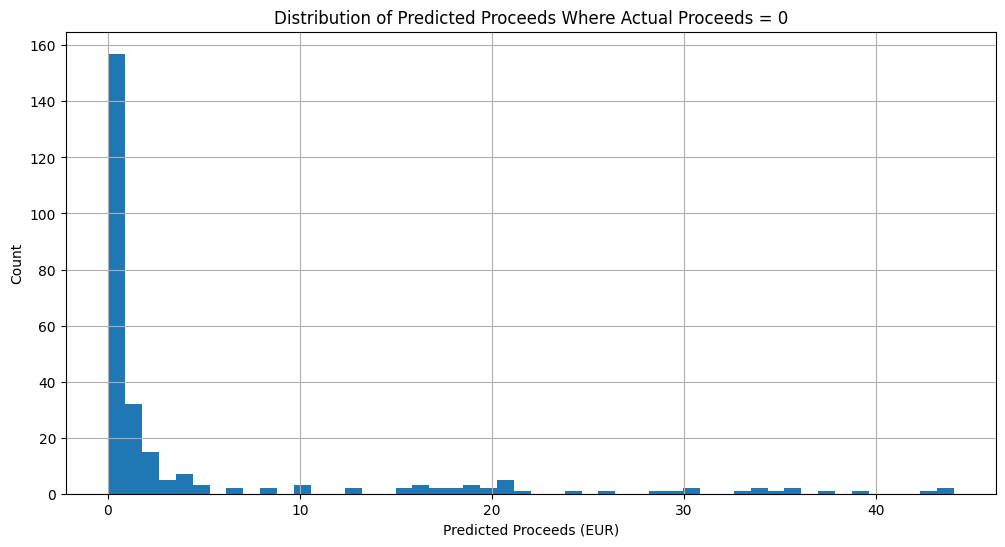

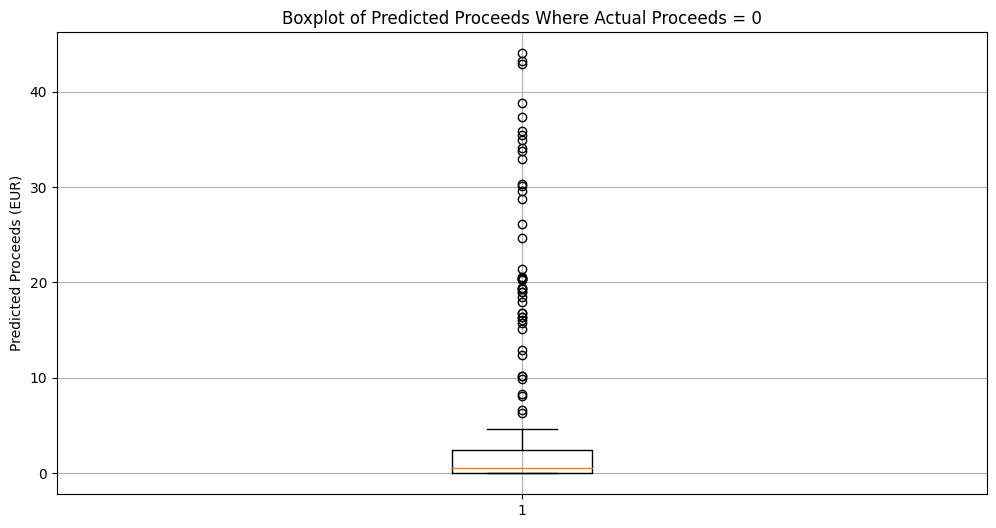

In [11]:
# Filter for rows where actual proceeds are zero
zero_proceeds = merged_df_clean[merged_df_clean['eur_proceeds_d8_new'] == 0]

print(f"Number of rows with zero actual proceeds: {len(zero_proceeds)}")

# Basic statistics of predictions for these rows
print("\nStatistics of predicted proceeds where actual proceeds = 0:")
print(zero_proceeds['eur_exp_proceeds_d8_new'].describe())

# Create histogram
plt.figure(figsize=(12, 6))
plt.hist(zero_proceeds['eur_exp_proceeds_d8_new'], bins=50)
plt.title('Distribution of Predicted Proceeds Where Actual Proceeds = 0')
plt.xlabel('Predicted Proceeds (EUR)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Optional: Show boxplot for better visualization of outliers
plt.figure(figsize=(12, 6))
plt.boxplot(zero_proceeds['eur_exp_proceeds_d8_new'])
plt.title('Boxplot of Predicted Proceeds Where Actual Proceeds = 0')
plt.ylabel('Predicted Proceeds (EUR)')
plt.grid(True)
plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.snowpark import Session
import config
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connect to Snowflake
def get_snowflake_session():
    connection_parameters = {
        "account": config.SNOWFLAKE_ACCOUNT,
        "user": config.SNOWFLAKE_USER,
        "role": config.SNOWFLAKE_ROLE,
        "warehouse": config.SNOWFLAKE_WAREHOUSE,
        "database": config.SNOWFLAKE_DATABASE,
        "schema": config.SNOWFLAKE_SCHEMA,
        "authenticator": config.SNOWFLAKE_AUTHENTICATOR
    }
    session = Session.builder.configs(connection_parameters).create()
    print(f"Connected to Snowflake as {config.SNOWFLAKE_USER}")
    return session

# Initialize Snowflake session
session = get_snowflake_session()

# Define table names
new_table = "BLINKIST_DEV.DBT_MJAAMA.AGGREGATED_EXPECTED_PROCEEDS_20250319"
prod_table = "BLINKIST_PRODUCTION.REPORTING.MARKETING_SIGNUP_EXP_ROI"

# Step 1: Get the dates available in the new table
print("Fetching available dates from new table...")
dates_query = f"""
SELECT DISTINCT CAST("report_date" AS DATE) AS report_date 
FROM {new_table}
ORDER BY report_date
"""
dates_df = session.sql(dates_query).to_pandas()
available_dates = dates_df['REPORT_DATE'].tolist()
print(f"Found {len(available_dates)} dates in new table: {available_dates}")

# Create date filter for queries
date_filter = ", ".join([f"'{date}'" for date in available_dates])

# Step 2: Fetch data from both tables with matching columns
print("\nFetching data from both tables...")
new_data_query = f"""
SELECT 
    CAST("report_date" AS DATE) AS report_date,
    "channel_group",
    "marketing_network_id",
    "account_id",
    "campaign_name",
    "campaign_id",
    "adgroup_name",
    "adgroup_id",
    "target_market",
    "total_users" AS signups,
    "total_spend" AS eur_marketing_spend,
    "eur_proceeds_d8",
    "expected_proceeds_d8" AS eur_exp_proceeds_d8
FROM {new_table}
WHERE CAST("report_date" AS DATE) IN ({date_filter})
"""

prod_data_query = f"""
SELECT 
    REPORT_DATE,
    CHANNEL_GROUP,
    MARKETING_NETWORK_ID,
    ACCOUNT_ID,
    CAMPAIGN_NAME,
    CAMPAIGN_ID,
    ADGROUP_NAME,
    ADGROUP_ID,
    TARGET_MARKET,
    SIGNUPS,
    EUR_MARKETING_SPEND,
    EUR_B2C_PROCEEDS_D8 AS EUR_PROCEEDS_D8,
    EUR_EXP_PROCEEDS_D8
FROM {prod_table}
WHERE REPORT_DATE IN ({date_filter})
"""

new_df = session.sql(new_data_query).to_pandas()
prod_df = session.sql(prod_data_query).to_pandas()

# Convert column names to lowercase for consistency
new_df.columns = new_df.columns.str.lower()
prod_df.columns = prod_df.columns.str.lower()

print(f"Retrieved {len(new_df)} rows from new table")
print(f"Retrieved {len(prod_df)} rows from production table")

# Check if we have data in both dataframes
if len(new_df) == 0 or len(prod_df) == 0:
    print("ERROR: One or both tables have no data for the specified dates.")
    if len(new_df) == 0:
        print("The new table has no data.")
    if len(prod_df) == 0:
        print("The production table has no data.")
    session.close()
    exit()

# Step 3: Create a join key for comparison
join_columns = [
    'report_date', 'channel_group', 'marketing_network_id', 'account_id', 
    'campaign_id', 'adgroup_id', 'target_market'
]

# Check if all join columns exist in both dataframes
missing_in_new = [col for col in join_columns if col not in new_df.columns]
missing_in_prod = [col for col in join_columns if col not in prod_df.columns]

if missing_in_new or missing_in_prod:
    print("ERROR: Some join columns are missing:")
    if missing_in_new:
        print(f"Missing in new table: {missing_in_new}")
    if missing_in_prod:
        print(f"Missing in production table: {missing_in_prod}")
    
    # Use only columns that exist in both dataframes
    join_columns = [col for col in join_columns if col in new_df.columns and col in prod_df.columns]
    print(f"Using reduced join columns: {join_columns}")
    
    if not join_columns:
        print("No common join columns found. Cannot proceed.")
        session.close()
        exit()

# Print sample values from join columns to help diagnose issues
print("\nSample values from join columns:")
for col in join_columns:
    print(f"\n{col} values in new table (first 5):")
    print(new_df[col].head().tolist())
    print(f"{col} values in production table (first 5):")
    print(prod_df[col].head().tolist())

# Create join keys
new_df['join_key'] = new_df[join_columns].astype(str).agg('|'.join, axis=1)
prod_df['join_key'] = prod_df[join_columns].astype(str).agg('|'.join, axis=1)

# Check for common join keys
common_keys = set(new_df['join_key']).intersection(set(prod_df['join_key']))
print(f"\nNumber of common join keys: {len(common_keys)}")

if len(common_keys) == 0:
    print("ERROR: No common join keys found between the tables.")
    print("This could be due to differences in data format or content.")
    
    # Try a more lenient join on fewer columns
    reduced_join_columns = ['report_date', 'channel_group', 'marketing_network_id']
    print(f"\nTrying a more lenient join on: {reduced_join_columns}")
    
    # Check if these columns exist
    if all(col in new_df.columns for col in reduced_join_columns) and all(col in prod_df.columns for col in reduced_join_columns):
        new_df['reduced_join_key'] = new_df[reduced_join_columns].astype(str).agg('|'.join, axis=1)
        prod_df['reduced_join_key'] = prod_df[reduced_join_columns].astype(str).agg('|'.join, axis=1)
        
        common_reduced_keys = set(new_df['reduced_join_key']).intersection(set(prod_df['reduced_join_key']))
        print(f"Number of common keys with reduced join: {len(common_reduced_keys)}")
        
        if len(common_reduced_keys) > 0:
            print("Proceeding with reduced join columns")
            join_columns = reduced_join_columns
            new_df['join_key'] = new_df['reduced_join_key']
            prod_df['join_key'] = prod_df['reduced_join_key']
        else:
            print("Still no common keys found. Cannot proceed with comparison.")
            session.close()
            exit()
    else:
        print("Cannot use reduced join columns. Exiting.")
        session.close()
        exit()

# Step 4: Merge datasets on join key
merged_df = pd.merge(
    new_df, 
    prod_df, 
    on='join_key', 
    how='inner',  # Only keep rows present in both tables
    suffixes=('_new', '_prod')
)

print(f"Common rows in both tables after merge: {len(merged_df)}")

if len(merged_df) == 0:
    print("ERROR: No common rows found after merging. Cannot proceed with comparison.")
    session.close()
    exit()

# Continue with the rest of the script only if we have data to compare
# Step 5: Verify actuals are the same
print("\nVerifying actuals between tables...")
actuals_columns = [
    ('eur_proceeds_d8_new', 'eur_proceeds_d8_prod'),
    ('eur_marketing_spend_new', 'eur_marketing_spend_prod'),
    ('signups_new', 'signups_prod')
]

for new_col, prod_col in actuals_columns:
    if new_col in merged_df.columns and prod_col in merged_df.columns:
        # Calculate absolute difference
        merged_df['diff'] = (merged_df[new_col] - merged_df[prod_col]).abs()
        
        # Calculate relative difference (percentage)
        merged_df['rel_diff'] = np.where(
            merged_df[prod_col] != 0,
            (merged_df['diff'] / merged_df[prod_col].abs()) * 100,
            np.where(merged_df[new_col] != 0, 100, 0)
        )
        
        # Set a threshold for significant differences (e.g., 1%)
        threshold = 1.0
        significant_diff = merged_df[merged_df['rel_diff'] > threshold]
        
        mean_diff = merged_df['diff'].mean()
        max_diff = merged_df['diff'].max()
        
        print(f"\n{new_col.replace('_new', '')} vs {prod_col.replace('_prod', '')}:")
        print(f"  Mean absolute difference: {mean_diff:.4f}")
        print(f"  Max absolute difference: {max_diff:.4f}")
        print(f"  Rows with >1% difference: {len(significant_diff)} ({len(significant_diff)/len(merged_df)*100:.2f}%)")
    else:
        print(f"Columns {new_col} and/or {prod_col} not found in merged dataframe")

# The rest of the script continues as before...

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://blinkist-useast_1_virginia.snowflakecomputing.com/console/login?login_name=meri-kris.jaama%40go1.com&browser_mode_redirect_port=59842&proof_key=sADukUbX75waBFs4keaJkKeplg6qgom9YCpaIEWSH5M%3D to authenticate...
Connected to Snowflake as meri-kris.jaama@go1.com
Fetching available dates from new table...
Found 46 dates in new table: [datetime.date(2025, 1, 21), datetime.date(2025, 1, 22), datetime.date(2025, 1, 23), datetime.date(2025, 1, 24), datetime.date(2025, 1, 25), datetime.date(2025, 1, 26), datetime.date(2025, 1, 27), datetime.date(2025, 1, 28), datetime.date(2025, 1, 29), datetime.date(2025, 1, 30), datetime.date(2025, 1, 31), datetime.date(2025, 2, 1), datetime.date(2025, 2, 2), datetime.date(2025, 2, 3), datetime.date(2025, 2

In [3]:


# Step 6: Compare prediction accuracy against actual values
print("\nComparing prediction accuracy against actual values...")

# Use a single actual value column to avoid confusion
merged_df['actual_proceeds_d8'] = merged_df['eur_proceeds_d8_new']

# Calculate error metrics for both models
metrics = []

# Calculate absolute error for each model
merged_df['abs_error_new'] = (merged_df['eur_exp_proceeds_d8_new'] - merged_df['actual_proceeds_d8']).abs()
merged_df['abs_error_prod'] = (merged_df['eur_exp_proceeds_d8_prod'] - merged_df['actual_proceeds_d8']).abs()

# Calculate percentage error for each model (avoiding division by zero)
merged_df['pct_error_new'] = np.where(
    merged_df['actual_proceeds_d8'] != 0,
    (merged_df['abs_error_new'] / merged_df['actual_proceeds_d8']) * 100,
    np.where(merged_df['eur_exp_proceeds_d8_new'] != 0, 100, 0)
)

merged_df['pct_error_prod'] = np.where(
    merged_df['actual_proceeds_d8'] != 0,
    (merged_df['abs_error_prod'] / merged_df['actual_proceeds_d8']) * 100,
    np.where(merged_df['eur_exp_proceeds_d8_prod'] != 0, 100, 0)
)

# Calculate which model is better for each row
merged_df['better_model'] = np.where(
    merged_df['abs_error_new'] < merged_df['abs_error_prod'], 
    'new', 
    np.where(
        merged_df['abs_error_new'] > merged_df['abs_error_prod'],
        'production',
        'equal'
    )
)

# Calculate overall metrics
mae_new = mean_absolute_error(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_new'])
mae_prod = mean_absolute_error(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_prod'])

rmse_new = np.sqrt(mean_squared_error(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_new']))
rmse_prod = np.sqrt(mean_squared_error(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_prod']))

r2_new = r2_score(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_new'])
r2_prod = r2_score(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_prod'])

# Calculate mean percentage error
mape_new = merged_df['pct_error_new'].mean()
mape_prod = merged_df['pct_error_prod'].mean()

# Count how many times each model is better
better_counts = merged_df['better_model'].value_counts()

print("\nOverall Error Metrics:")
print(f"Mean Absolute Error (MAE):")
print(f"  New model: {mae_new:.4f}")
print(f"  Production model: {mae_prod:.4f}")
print(f"  Improvement: {(1 - mae_new/mae_prod)*100:.2f}%")

print(f"\nRoot Mean Squared Error (RMSE):")
print(f"  New model: {rmse_new:.4f}")
print(f"  Production model: {rmse_prod:.4f}")
print(f"  Improvement: {(1 - rmse_new/rmse_prod)*100:.2f}%")

print(f"\nMean Absolute Percentage Error (MAPE):")
print(f"  New model: {mape_new:.2f}%")
print(f"  Production model: {mape_prod:.2f}%")
print(f"  Improvement: {(1 - mape_new/mape_prod)*100:.2f}%")

print(f"\nR² Score:")
print(f"  New model: {r2_new:.4f}")
print(f"  Production model: {r2_prod:.4f}")
print(f"  Difference: {r2_new - r2_prod:.4f}")

print("\nBetter Model Counts:")
for model, count in better_counts.items():
    print(f"  {model.capitalize()}: {count} rows ({count/len(merged_df)*100:.2f}%)")

# Step 7: Analyze by channel_group
print("\nAnalyzing prediction accuracy by channel_group...")
channel_groups = merged_df['channel_group_new'].unique()

channel_metrics = []

for channel in channel_groups:
    channel_data = merged_df[merged_df['channel_group_new'] == channel]
    
    if len(channel_data) == 0:
        continue
    
    # Calculate metrics for this channel
    channel_mae_new = mean_absolute_error(channel_data['actual_proceeds_d8'], channel_data['eur_exp_proceeds_d8_new'])
    channel_mae_prod = mean_absolute_error(channel_data['actual_proceeds_d8'], channel_data['eur_exp_proceeds_d8_prod'])
    
    channel_mape_new = channel_data['pct_error_new'].mean()
    channel_mape_prod = channel_data['pct_error_prod'].mean()
    
    # Count better model for this channel
    channel_better = channel_data['better_model'].value_counts()
    new_better_pct = channel_better.get('new', 0) / len(channel_data) * 100
    
    channel_metrics.append({
        'Channel': channel,
        'Count': len(channel_data),
        'MAE New': channel_mae_new,
        'MAE Prod': channel_mae_prod,
        'MAE Improvement %': (1 - channel_mae_new/channel_mae_prod)*100 if channel_mae_prod > 0 else 0,
        'MAPE New %': channel_mape_new,
        'MAPE Prod %': channel_mape_prod,
        'MAPE Improvement %': (1 - channel_mape_new/channel_mape_prod)*100 if channel_mape_prod > 0 else 0,
        'New Better %': new_better_pct
    })
    
    print(f"\nChannel: {channel} ({len(channel_data)} rows)")
    print(f"  MAE: New={channel_mae_new:.4f}, Prod={channel_mae_prod:.4f}, Improvement={(1 - channel_mae_new/channel_mae_prod)*100:.2f}%")
    print(f"  MAPE: New={channel_mape_new:.2f}%, Prod={channel_mape_prod:.2f}%, Improvement={(1 - channel_mape_new/channel_mape_prod)*100:.2f}%")
    print(f"  New model better: {new_better_pct:.2f}% of rows")

# Create channel metrics dataframe
channel_metrics_df = pd.DataFrame(channel_metrics)
channel_metrics_df = channel_metrics_df.sort_values('Count', ascending=False)

print("\nChannel Metrics Summary:")
display(channel_metrics_df)

# Step 8: Visualize the comparison
print("\nCreating visualizations...")

# Scatter plot of actual vs predicted for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_new'], alpha=0.5)
plt.plot([0, merged_df['actual_proceeds_d8'].max()], [0, merged_df['actual_proceeds_d8'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('New Model Predicted Proceeds D8')
plt.title('New Model: Actual vs Predicted')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(merged_df['actual_proceeds_d8'], merged_df['eur_exp_proceeds_d8_prod'], alpha=0.5)
plt.plot([0, merged_df['actual_proceeds_d8'].max()], [0, merged_df['actual_proceeds_d8'].max()], 'r--')
plt.xlabel('Actual Proceeds D8')
plt.ylabel('Production Model Predicted Proceeds D8')
plt.title('Production Model: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# Histogram of absolute errors for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(merged_df['abs_error_new'].clip(0, merged_df['abs_error_new'].quantile(0.95)), bins=50)
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.title('New Model: Distribution of Absolute Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(merged_df['abs_error_prod'].clip(0, merged_df['abs_error_prod'].quantile(0.95)), bins=50)
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.title('Production Model: Distribution of Absolute Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

# Histogram of percentage errors for both models
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(merged_df['pct_error_new'].clip(0, 100), bins=50)
plt.xlabel('Percentage Error')
plt.ylabel('Count')
plt.title('New Model: Distribution of Percentage Errors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(merged_df['pct_error_prod'].clip(0, 100), bins=50)
plt.xlabel('Percentage Error')
plt.ylabel('Count')
plt.title('Production Model: Distribution of Percentage Errors')
plt.grid(True)

plt.tight_layout()
plt.show()

# Bar chart of channel performance
plt.figure(figsize=(12, 8))
channels = channel_metrics_df['Channel'].tolist()
new_mae = channel_metrics_df['MAE New'].tolist()
prod_mae = channel_metrics_df['MAE Prod'].tolist()

x = np.arange(len(channels))
width = 0.35

plt.bar(x - width/2, new_mae, width, label='New Model')
plt.bar(x + width/2, prod_mae, width, label='Production Model')

plt.xlabel('Channel')
plt.ylabel('Mean Absolute Error')
plt.title('MAE by Channel')
plt.xticks(x, channels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Save results to CSV for further analysis
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
merged_df.to_csv(f"model_comparison_{timestamp}.csv", index=False)
channel_metrics_df.to_csv(f"channel_metrics_{timestamp}.csv", index=False)

print(f"\nResults saved to CSV files: model_comparison_{timestamp}.csv and channel_metrics_{timestamp}.csv")

# Close Snowflake session
session.close()
print("\nSnowflake session closed")


Comparing prediction accuracy against actual values...


ValueError: Input contains NaN.